In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
SCOL_NAME = "20000_90"

In [3]:
#set paths 
STORMS_PATH  = "/shared/3/projects/newsDiffusion/data/processed/stormDfs/20000_90_storms.tsv"
ARTICLES_PATH = "/shared/3/projects/newsDiffusion/data/processed/fullDataWith20000.tsv"
POLITICS_PATH = "/shared/3/projects/newsDiffusion/data/raw/NELAdata/CSVs/politics.csv"
VER_2020 = "/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2020/labels.csv"
VER_2021 = "/shared/3/projects/newsDiffusion/data/raw/NELA-gt-2021/labels_all.tab"

#read data
ver2020 = pd.read_csv(VER_2020)
ver2021 = pd.read_csv(VER_2021, sep="\t")
politics = pd.read_csv(POLITICS_PATH)
stormsDf = pd.read_csv(STORMS_PATH, sep="\t")
artDf = pd.read_csv(ARTICLES_PATH, sep="\t")

#clean up dframes 
artDf["date"] = pd.to_datetime(artDf["date"])
artDf = artDf.drop(columns=["Unnamed: 0"])
stormsDf = stormsDf.drop(columns=["Unnamed: 0", SCOL_NAME])

#only keep articles after april 4th, that's when local coverage started 
artDf = artDf[artDf["date"] > "2020-04-01"]

F_COLOR = "#fdae61"
S_COLOR = "#abdda4"

<ipython-input-3-0089648ec02c>:13: DtypeWarning: Columns (4,5,12,13,15,16,19) have mixed types. Specify dtype option on import or set low_memory=False.
  artDf = pd.read_csv(ARTICLES_PATH, sep="\t")


In [446]:
artDf.columns

Index(['Unnamed: 0.2', 'Unnamed: 0.1', 'key', 'local_id', 'sourcedomain_id',
       'date', 'title', 'content', 'url', 'fips', 'source', 'description',
       'onlinesince', 'rank', 'state', 'city', 'lon', 'lat', 'county',
       'total_population', 'white_pct', 'black_pct', 'hispanic_pct',
       'nonwhite_pct', 'foreignborn_pct', 'female_pct', 'age29andunder_pct',
       'age65andolder_pct', 'median_hh_inc', 'clf_unemploy_pct', 'lesshs_pct',
       'lesscollege_pct', 'lesshs_whites_pct', 'lesscollege_whites_pct',
       'rural_pct', 'ruralurban_cc', 'predrt_0', 'predrt_12', 'predrt_3',
       'national', 'id', 'author', 'published', 'published_utc',
       'collection_utc', '20000_80', '20000_85', '20000_90', 'year'],
      dtype='object')

In [5]:
#fill in the clusters of size 1 that have no cluster label 
clustList = list(artDf[SCOL_NAME])
clustNum = np.nanmax(clustList) + 1

for i, num in enumerate(clustList): 
    currClust = num
    if num != num: 
        clustList[i] = clustNum 
        clustNum += 1
    

artDf[SCOL_NAME] = clustList
artDf[SCOL_NAME] = artDf[SCOL_NAME].astype(int)

In [197]:
def storyLen(inList): 
    return (max(inList) - min(inList)) / np.timedelta64(1,"D")

#get features of each cluster
test = artDf[[SCOL_NAME, "date"]].groupby(SCOL_NAME).agg(list)

test["nArts"] = test["date"].apply(len)

test["storyLen"] = test["date"].apply(storyLen)

test = test.reset_index().drop(columns=["date"])

In [198]:
#fill na in 2021 with 2020 ratings 
sourceDf = pd.merge(ver2020, ver2021[["source","label"]], on="source", how="outer")
sourceDf["label"] = sourceDf["label_y"].fillna(sourceDf["label_x"])

#get local/national labels 
localNat = artDf[["source", "national"]].drop_duplicates()
sourceDf = pd.merge(sourceDf, localNat, on="source", how="outer")

#we want outlets with both local and national classification to be local 
sourceDf = sourceDf.sort_values("national").drop_duplicates(subset=["source"])

sourceDf.loc[(sourceDf["source"] == "charlotteobserver"), ["national"]] = False

#only item with a -1 reliability that matters/is relevant is forbes... 
#should be rated "reliable"
sourceDf.loc[sourceDf["source"] == "forbes", "label"] = 0

#if we have nat/local duplicates, call them local 
sourceDf = sourceDf.sort_values("national").drop_duplicates(subset=["source"])

sourceDf = sourceDf.rename(columns={"label":"verLab"})

In [200]:

#perform the necessary merging 
merged = pd.merge(artDf.drop(columns=["national"]), sourceDf[["source", "verLab", "national"]], on="source", how="left")

merged = pd.merge(merged, politics, on="fips", how="left")
merged = pd.merge(merged, stormsDf, on="key", how="left")
merged[SCOL_NAME + "_storm"] = merged[SCOL_NAME + "_storm"].fillna(False)

merged = pd.merge(merged, test, on=SCOL_NAME, how="left")

In [202]:
sum(merged["key"].duplicated())

0

In [8]:
#now we want to get the time series for each storm and plot it. 

#if it seems logical, we can fit parametric curves? 

In [116]:
dateDf = merged.loc[merged[SCOL_NAME + "_storm"], [SCOL_NAME, "date", "rural_pct", "national"]].groupby(by=[SCOL_NAME]).agg(list)
dateDf.head()

,date,rural_pct,national
20000_90,,,
359,"[2020-07-07 00:00:00, 2020-07-07 00:00:00, 202...","[nan, nan, nan, nan, nan, nan, 4.1955192253125...","[True, True, True, True, True, True, False, Tr..."
533,"[2020-09-18 00:00:00, 2020-09-18 00:00:00, 202...","[nan, nan, nan, nan, nan, nan, nan, nan, nan, ...","[True, True, True, True, True, True, True, Tru..."
608,"[2020-11-03 00:00:00, 2020-11-03 00:00:00, 202...","[nan, nan, 37.1145605465824, 62.736, 40.986060...","[False, True, False, False, False, False, Fals..."
1312,"[2021-05-10 00:00:00, 2021-05-10 00:00:00, 202...","[4.19551922531257, 2.22496040957112, nan, nan,...","[False, False, True, True, True, False, False,..."
1628,"[2021-07-01 00:00:00, 2021-07-01 00:00:00, 202...","[63.5115738928469, nan, nan, nan, 48.391736040...","[False, True, True, True, False, True, True, F..."


In [203]:
from collections import Counter

def getPeakDay(inList): 
    return Counter(inList).most_common()[0][0]

def getFirstDay(inList): 
    return min(inList)


#first find peak coverage 
dateDf = merged.loc[merged[SCOL_NAME + "_storm"], [SCOL_NAME, "date", "national", "rural_pct", "state"]].groupby(by=[SCOL_NAME]).agg(list) #.agg(len)

In [204]:
dateDf["totalArts"] = dateDf["date"].apply(len)
dateDf["peakDay"] = pd.to_datetime(dateDf["date"].apply(getPeakDay))
dateDf["firstDay"] = pd.to_datetime(dateDf["date"].apply(getFirstDay))

dateDf = dateDf.explode(["date", "rural_pct", "national", "state"])

dateDf["fDayNorm"] = ((dateDf["date"] - dateDf["firstDay"]) / np.timedelta64(1, "D")).astype(int)
dateDf["pDayNorm"] = ((dateDf["date"] - dateDf["peakDay"]) / np.timedelta64(1, "D")).astype(int)



In [213]:
#get the day of peak 
#only need one row per storm 
peakDf = dateDf.reset_index().drop_duplicates(subset=[SCOL_NAME])[[SCOL_NAME, "peakDay", "firstDay"]]
peakDf["peakDayInt"] = (peakDf["peakDay"] - peakDf["firstDay"]) / np.timedelta64(1, "D")

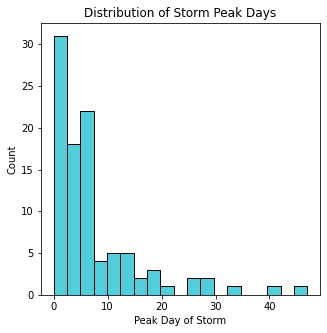

In [497]:
fig, ax = plt.subplots(figsize=(5, 5))

sns.histplot(data=peakDf, x="peakDayInt", ax=ax, color=colDict["turqoise"])
ax.set_title("Distribution of Storm Peak Days")
ax.set_xlabel("Peak Day of Storm")
ax.set_ylabel("Count")

plt.savefig(FIG_PATH + "peakDay.pdf", bbox_inches="tight")

In [307]:
np.mean(peakDf["peakDayInt"])
np.median(peakDf["peakDayInt"])

4.5

0.8469387755102041

In [217]:
peakDf[peakDf["peakDayInt"] >= 15]

,20000_90,peakDay,firstDay,peakDayInt
2745,1917,2021-08-27,2021-08-09,18.0
3089,2195,2021-09-15,2021-08-27,19.0
6914,5158,2021-06-04,2021-05-07,28.0
7738,5381,2021-08-10,2021-07-15,26.0
8870,5773,2021-11-03,2021-09-30,34.0
9443,6781,2020-10-08,2020-09-17,21.0
10073,6876,2020-10-27,2020-10-10,17.0
10937,8088,2021-04-20,2021-03-04,47.0
13836,14119,2020-05-01,2020-04-12,19.0
15827,28369,2021-12-23,2021-11-28,25.0


In [248]:
len(peakDf[peakDf["peakDayInt"] >= 15]) 

13

In [247]:
len(peakDf[peakDf["peakDayInt"] >= 15]) / len(peakDf)

0.1326530612244898

In [220]:
#stories which peak on or after day 15 
stormRows = merged.loc[merged[SCOL_NAME + "_storm"] == True]

In [345]:
stormRows.sample(20)

,Unnamed: 0.2,Unnamed: 0.1,key,local_id,sourcedomain_id,date,title,content,url,fips,...,national,logodds_Trump20,logodds_Trump16,logodds_Romney12,20000_90_average_pct,20000_90_num_over_cutoff,20000_90_storm_source,20000_90_storm,nArts,storyLen
3155207,3500266,4770364,4770364,NaN,NaN,2021-07-16,Biden says platforms like Facebook are ‘killin...,The White House escalated its fight against va...,https://www.theverge.com/2021/7/16/22580620/bi...,NaN,...,True,NaN,NaN,NaN,0.162162,6.0,"['truepundit', 'thenewyorktimes', 'thebl', 'rt...",True,88,9.0
1138590,1483649,2275878,2275878,NaN,NaN,2020-09-14,Q&A: What does a deal between TikTok and Oracl...,"Microsoft , which had been vying for a deal , ...",https://www.mail.com/news/politics/10174290-qa...,NaN,...,True,NaN,NaN,NaN,0.157895,6.0,"['waterburyrepublicanamerican', 'rt', 'npr', '...",True,81,8.0
1613836,1958895,1981762,1981762,NaN,NaN,2020-11-22,Trump legal team: ‘Anticipated’ Pennsylvania l...,President Donald Trump ’ s legal team on Satur...,https://thebl.com/us-news/trump-legal-team-ant...,NaN,...,True,NaN,NaN,NaN,0.125000,8.0,"['yahoonews', 'saintpaulpioneerpress', 'pbs', ...",True,161,15.0
1004736,1349795,369538,369538,moberlymonitorindex--2020-08-24--Postal leader...,moberlymonitorindex-moberlymonitor.com,2020-08-24,"Postal leader defends changes, denies 'sabotag...",WASHINGTON — Postmaster General Louis DeJoy to...,https://www.moberlymonitor.com/zz/news/2020082...,29175.0,...,False,1.171416,1.193272,0.788277,0.256757,19.0,"['westhawaiitoday', 'thetribunechronicle', 'th...",True,363,11.0
2480546,2825605,3763207,3763207,NaN,NaN,2021-04-01,"""The System of Policing Is on Trial"": Derek Ch...",This is a rush transcript .\nCopy may not be i...,http://www.democracynow.org/2021/4/1/derek_cha...,NaN,...,True,NaN,NaN,NaN,0.427184,44.0,"['westhawaiitoday', 'westcentraltribune', 'wat...",True,1378,53.0
3602774,3947833,3562457,3562457,NaN,NaN,2021-09-23,Giant sequoia burns in California wildfire as ...,A giant sequoia has been significantly damaged...,https://www.independent.co.uk/climate-change/n...,NaN,...,True,NaN,NaN,NaN,0.131579,5.0,"['thehuffingtonpost', 'npr', 'mail', 'latimes'...",True,111,9.0
2395552,2740611,1343820,1343820,wadenapioneerjournal--2021-03-19--Judge will n...,wadenapioneerjournal-wadenapj.com,2021-03-19,Judge will not move or delay Derek Chauvin tri...,MINNEAPOLIS — The judge in the trial of Derek ...,https://www.wadenapj.com/derek-chauvin-trial/6...,27159.0,...,False,1.003796,1.055123,0.508335,0.427184,44.0,"['westhawaiitoday', 'westcentraltribune', 'wat...",True,1378,53.0
4031451,4376510,3426693,3426693,NaN,NaN,2021-11-30,BREAKING: CNN 'Indefinitely Suspends' Chris Cuomo,And there it is .\nMultiple media outlets are ...,https://redstate.com/mike_miller/2021/11/30/br...,NaN,...,True,NaN,NaN,NaN,0.278481,22.0,"['usatoday', 'thelowellsun', 'thegatewaypundit...",True,337,9.0
3823201,4168260,3802563,3802563,NaN,NaN,2021-10-28,Poll: Republican Glenn Youngkin Ahead of Democ...,Republican Glenn Youngkin has pulled ahead of ...,http://feedproxy.google.com/~r/breitbart/~3/yV...,NaN,...,True,NaN,NaN,NaN,0.111111,5.0,"['yahoonews', 'politicalwire', 'newsmax', 'mai...",True,132,36.0
3432459,3777518,982869,982869,bostonherald--2021-08-28--Hurricane Ida takes ...,bostonherald-bostonherald.com,2021-08-28,Hurricane Ida takes form and aims at US Gulf C...,"ORLANDO, Fla. — Ida grew into a Category 1 hur...",https://www.bostonherald.com/2021/08/27/hurric...,25025.0,...,False,-1.512086,-1.583911,-1.316854,0.428571,24.0,"['westhawaiitoday', 'washingtontimes', 'therep...",True,289,7.0


In [361]:
stormRows["date"]

18127     2020-04-05
18151     2020-04-05
18269     2020-04-05
18342     2020-04-05
18730     2020-04-05
             ...    
4209511   2021-12-29
4211014   2021-12-29
4216886   2021-12-30
4218806   2021-12-31
4219230   2021-12-31
Name: date, Length: 20331, dtype: datetime64[ns]

In [430]:
#chauvin
chauvinRows = stormRows.loc[stormRows[SCOL_NAME] == 8088]
#chauvinRows[["date", "key"]].groupby("date").agg(len)
chauvinRows["dummy"] = 1

#chauvinRows = chauvinRows.set_index("date")

<ipython-input-430-f20137bbd7d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chauvinRows["dummy"] = 1


In [431]:
import matplotlib.ticker as ticker

In [432]:
idx

PeriodIndex(['2021-03-04', '2021-03-05', '2021-03-06', '2021-03-07',
             '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11',
             '2021-03-12', '2021-03-13', '2021-03-14', '2021-03-15',
             '2021-03-16', '2021-03-17', '2021-03-18', '2021-03-19',
             '2021-03-20', '2021-03-21', '2021-03-22', '2021-03-23',
             '2021-03-24', '2021-03-25', '2021-03-26', '2021-03-27',
             '2021-03-28', '2021-03-29', '2021-03-30', '2021-03-31',
             '2021-04-01', '2021-04-02', '2021-04-03', '2021-04-04',
             '2021-04-05', '2021-04-06', '2021-04-07', '2021-04-08',
             '2021-04-09', '2021-04-10', '2021-04-11', '2021-04-12',
             '2021-04-13', '2021-04-14', '2021-04-15', '2021-04-16',
             '2021-04-17', '2021-04-18', '2021-04-19', '2021-04-20',
             '2021-04-21', '2021-04-22', '2021-04-23', '2021-04-24',
             '2021-04-25', '2021-04-26'],
            dtype='period[D]')

In [462]:
tab10

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [459]:
tab10 = sns.color_palette("tab10")

colNames = ["blue", "orange", "green", "red", "purple", "brown", "pink", "grey", "yellow", "turqoise"]
colDict = dict(zip(colNames, tab10))

In [466]:
colDict

{'blue': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'orange': (1.0, 0.4980392156862745, 0.054901960784313725),
 'green': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 'red': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'purple': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'brown': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'pink': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 'grey': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 'turqoise': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)}

<ipython-input-469-67a0c23a1ab0>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', size=12)


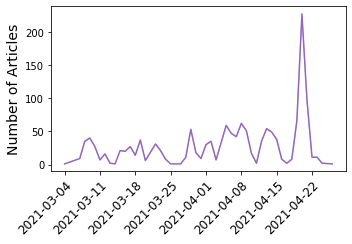

In [469]:
#idx = pd.period_range(min(chauvinRows.index), max(chauvinRows.index))
#chauvinRows = chauvinRows.reindex(idx, fill_value=0)
        
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.lineplot(data=chauvinRows, x="date", y="dummy", estimator=sum, color=colDict["purple"])

ax.set_ylabel("Number of Articles", size=14)
ax.set_xlabel("")

ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor', size=12)
#ax.set_title("Derek Chauvin's Court Case")
plt.tight_layout()

plt.savefig(FIG_PATH + "chauvinSeries.pdf", dpi=600, bbox_inches="tight")

In [458]:
sns.color_palette("tab10")[0]

(0.12156862745098039, 0.4666666666666667, 0.7058823529411765)

In [ ]:
#jury selection begins on ninth? 
#jury selection resumes around 14th? 
#attempts to delay or move the trial around the 15th 
#jury is set around 24th 
#evidence shown 29 - and testimony 

chauvinRows

In [470]:
#get some stuff to annotate with 
#list(chauvinRows.sort_values("date").iloc[60:70]["title"])
#chauvinRows.sort_values("date")[(chauvinRows["date"] >= "2021-04-05") & (chauvinRows["date"] <= "2021-04-20")]
#chauvinRows.sort_values("date")[(chauvinRows["date"] >= "2021-03-08") & (chauvinRows["date"] <= "2021-03-08")]
#list(chauvinRows[chauvinRows["key"] ==  	4444180]["content"])

In [245]:
currStorm = 183029

cStorm = stormRows[stormRows[SCOL_NAME] == currStorm].sample(30).sort_values("date")
for i, row in cStorm.iterrows(): 
    print(row["source"])
    print(row["date"])
    print(row["title"])

pineriverjournal
2021-08-25 00:00:00
Minnesota health officials report 1,400 new COVID-19 cases, 7 deaths
pineriverjournal
2021-08-26 00:00:00
Minnesota reports 1,800 new COVID-19 infections, 11 deaths
echopress
2021-08-26 00:00:00
Minnesota reports 1,800 new COVID-19 infections, 11 deaths
detroitlakestribune
2021-08-26 00:00:00
Minnesota reports 1,800 new COVID-19 infections, 11 deaths
thebrainerddailydispatch
2021-08-31 00:00:00
Minnesota reports 3,800 additional COVID-19 infections, 6 deaths
dailyglobe
2021-08-31 00:00:00
Minnesota reports 3,800 additional COVID-19 infections, 6 deaths
echopress
2021-09-01 00:00:00
Minnesota reports 1,400 new COVID-19 cases, 6 deaths
dailyglobe
2021-09-01 00:00:00
Minnesota reports 1,400 new COVID-19 cases, 6 deaths
thebrainerddailydispatch
2021-09-02 00:00:00
Minnesota reports 1,900 new COVID-19 cases, 22 deaths
wadenapioneerjournal
2021-09-02 00:00:00
Minnesota reports 1,900 new COVID-19 cases, 22 deaths
echopress
2021-09-02 00:00:00
Minnesota rep

In [ ]:
# fp: 2
# expectation of event: 8
# not expected: 1
# covid: 2

In [ ]:
#1915 - mix of texas and florida mask bans
#2195 - recall election, Gavin Newsom is gov. Surge up to recall results 
#5158 - buildup in anticipation of Biden's infrastructure bill. Turn towards bipartisanship 
#5381 - Passing of the infrastructure bill through the senate 
#5773- Buildup to race, through Glenn Youngkin's victory 
#6781 - Buildup to second debate and cancellation due to Trump having COVID? 
#6876 - Amy Coney Barrett's confirmation hearings and hearings 
#8088 - Trial of Derek Chauvin - peaks 47 days after
#14119 - Ongoing coverage of Tara Reade
#28369 - Coverage leading to conviction of Kim Potter in Daunte Wright Killing
#108922 - Coverage of COVID in Minnesota. Decline in cases in early June through an increase in coverage in late june/early july 
#130664 - Weekly updates on COVID 
#183029 - Additional storm on Minnesota's COVID cases, August - September 

In [128]:
def getFirst(inList): 
    return list(inList)[0]

dateCounts = dateDf.reset_index()[[SCOL_NAME, "pDayNorm", "totalArts", "national", "state", "rural_pct"]].groupby(by=[SCOL_NAME, "pDayNorm"])\
.agg(list) #.reset_index() #.head(30)

dateCounts["artCount"] = dateCounts["totalArts"].apply(len)
dateCounts["totalArts"] = dateCounts["totalArts"].apply(getFirst)

dateCounts["countNorm"] = dateCounts["artCount"] / dateCounts["totalArts"]

In [135]:
id=dateCounts.index.get_level_values(1)
idx=pd.MultiIndex.from_product([dateCounts.index.levels[0],list(range(int(id.min()),int(id.max())))])
dateCounts = dateCounts.reindex(idx, fill_value=0).reset_index()

dateCounts = dateCounts.rename(columns={"level_1":"pDayNorm"})

<ipython-input-14-81b88cfd9370>:2: UserWarning: 
The palette list has fewer values (1) than needed (98) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="pDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.1, palette=["blue"], legend=False, ax=ax)


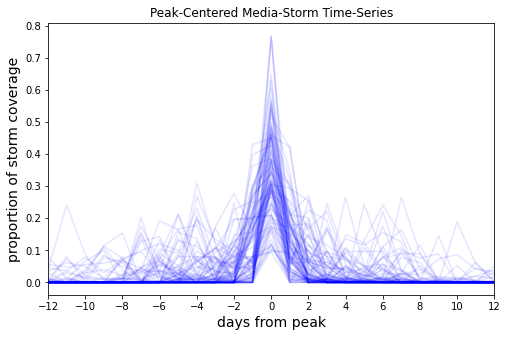

In [14]:
fix, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x="pDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.1, palette=["blue"], legend=False, ax=ax)
ax.set_xlim(-12, 12.01)
ax.set_title("Peak-Centered Media-Storm Time-Series")
ax.set_xlabel("days from peak", size=14)
ax.set_ylabel("proportion of storm coverage", size=14)
ax.set_xticks(np.arange(-12, 13, 2))

<ipython-input-15-1828ed767395>:2: UserWarning: 
The palette list has fewer values (1) than needed (98) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="pDayNorm", y="artCount", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.1, palette=["blue"], legend=False, ax=ax)


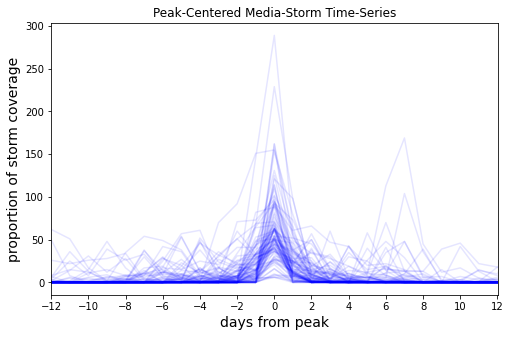

In [15]:
fix, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x="pDayNorm", y="artCount", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.1, palette=["blue"], legend=False, ax=ax)
ax.set_xlim(-12, 12.01)
ax.set_title("Peak-Centered Media-Storm Time-Series")
ax.set_xlabel("days from peak", size=14)
ax.set_ylabel("proportion of storm coverage", size=14)
ax.set_xticks(np.arange(-12, 13, 2))

In [16]:
#try the same thing but centering on day zero 

In [473]:
dateCounts = dateDf.reset_index()[[SCOL_NAME, "fDayNorm", "totalArts", "rural_pct", "national", "state"]].groupby(by=[SCOL_NAME, "fDayNorm"])\
.agg(list) #.reset_index() #.head(30)

dateCounts["artCount"] = dateCounts["totalArts"].apply(len)
dateCounts["totalArts"] = dateCounts["totalArts"].apply(getFirst)

dateCounts["countNorm"] = dateCounts["artCount"] / dateCounts["totalArts"]

In [474]:
dateCounts["national"] = dateCounts["national"].apply(np.nanmean)
dateCounts["rural_pct"] = dateCounts["rural_pct"].apply(np.nanmean)

dateCounts["state"] = dateCounts["state"].apply(lambda x: set([item for item in x if item == item]))

/opt/anaconda/lib/python3.8/site-packages/pandas/core/apply.py:1076: RuntimeWarning: Mean of empty slice
  mapped = lib.map_infer(


In [475]:
dateCounts["uniqueStates"] = dateCounts["state"].apply(len)

In [476]:
dateCounts["rural_pct"] = dateCounts["rural_pct"].fillna(0)

In [477]:
id=dateCounts.index.get_level_values(1)
idx=pd.MultiIndex.from_product([dateCounts.index.levels[0],list(range(int(id.min()),int(id.max())))])
dateCounts = dateCounts.reindex(idx, fill_value=0).reset_index()

dateCounts = dateCounts.rename(columns={"level_1":"fDayNorm"})

In [478]:
import random

In [479]:
#can be used to just look at a few storms 
sampleStorms = random.sample(list(dateCounts[SCOL_NAME].unique()), 1)
sampleCounts = dateCounts[dateCounts[SCOL_NAME].isin(sampleStorms)]

<ipython-input-480-892b55901f4f>:2: UserWarning: 
The palette list has fewer values (1) than needed (98) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="fDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False)


Text(0, 0.5, 'proportion of storm coverage')

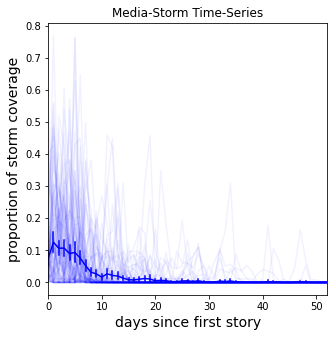

In [480]:
fix, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(x="fDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False)
sns.lineplot(x="fDayNorm", y="countNorm",data=dateCounts.reset_index(), ax=ax, color="blue", err_style="bars")
ax.set_xlim(0, 52)
ax.set_title("Media-Storm Time-Series")
ax.set_xlabel("days since first story", size=14)
ax.set_ylabel("proportion of storm coverage", size=14)
#ax.set_xticks(np.arange(-4, 4, 1))

<ipython-input-481-e0ad0e29bc26>:2: UserWarning: 
The palette list has fewer values (1) than needed (98) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="fDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False)


Text(0, 0.5, 'proportion of storm coverage')

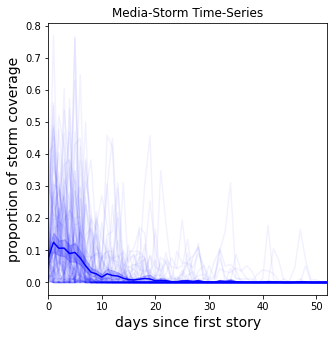

In [481]:
fix, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(x="fDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False)
sns.lineplot(x="fDayNorm", y="countNorm",data=dateCounts.reset_index(), ax=ax, color="blue", err_style="band")
ax.set_xlim(0, 52)
ax.set_title("Media-Storm Time-Series")
ax.set_xlabel("days since first story", size=14)
ax.set_ylabel("proportion of storm coverage", size=14)
#ax.set_xticks(np.arange(-4, 4, 1))

<ipython-input-482-892b55901f4f>:2: UserWarning: 
The palette list has fewer values (1) than needed (98) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="fDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False)


Text(0, 0.5, 'proportion of storm coverage')

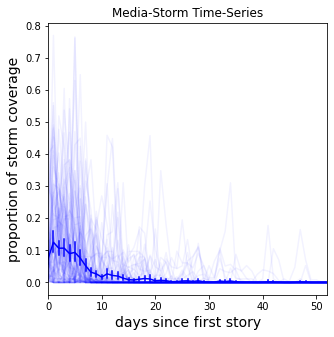

In [482]:
fix, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(x="fDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False)
sns.lineplot(x="fDayNorm", y="countNorm",data=dateCounts.reset_index(), ax=ax, color="blue", err_style="bars")
ax.set_xlim(0, 52)
ax.set_title("Media-Storm Time-Series")
ax.set_xlabel("days since first story", size=14)
ax.set_ylabel("proportion of storm coverage", size=14)
#ax.set_xticks(np.arange(-4, 4, 1))

<ipython-input-483-f363a051584b>:2: UserWarning: 
The palette list has fewer values (1) than needed (98) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="fDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False)


Text(0, 0.5, 'proportion of storm coverage')

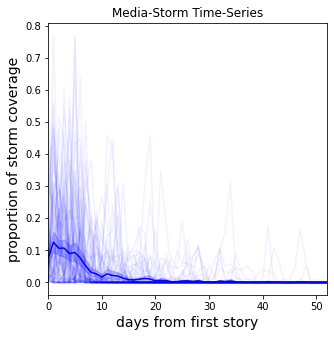

In [483]:
fix, ax = plt.subplots(figsize=(5, 5))
sns.lineplot(x="fDayNorm", y="countNorm", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False)
sns.lineplot(x="fDayNorm", y="countNorm",data=dateCounts.reset_index(), ax=ax, color="blue")
ax.set_xlim(0, 52)
ax.set_title("Media-Storm Time-Series")
ax.set_xlabel("days from first story", size=14)
ax.set_ylabel("proportion of storm coverage", size=14)
#ax.set_xticks(np.arange(-4, 4, 1))

In [484]:
dateCounts["sqrtCount"] = np.sqrt(dateCounts["artCount"])

<ipython-input-485-fdfdd0770097>:2: UserWarning: 
The palette list has fewer values (1) than needed (98) and will cycle, which may produce an uninterpretable plot.
  sns.lineplot(x="fDayNorm", y="sqrtCount", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False, ax=ax)


Text(0, 0.5, 'number of articles')

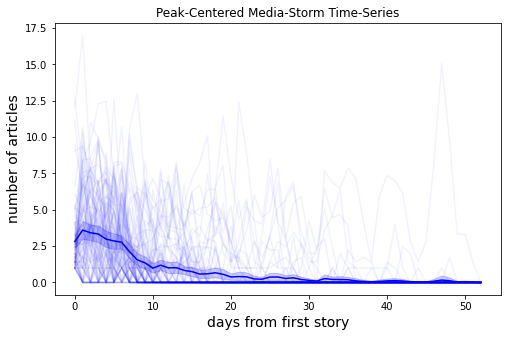

In [485]:
fix, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x="fDayNorm", y="sqrtCount", hue=SCOL_NAME, data=dateCounts.reset_index(), alpha=.05, palette=["blue"], legend=False, ax=ax)
sns.lineplot(x="fDayNorm", y="sqrtCount",data=dateCounts.reset_index(), ax=ax, color="blue")
ax.set_title("Peak-Centered Media-Storm Time-Series")
ax.set_xlabel("days from first story", size=14)
ax.set_ylabel("number of articles", size=14)
#ax.set_xticks(np.arange(-4, 4, 1))

In [486]:
FIG_PATH = "/home/blitt/projects/localNews/reports/figures/drafts/"
PALETTE = [ "#008837", "#7b3294"]

In [487]:
#START HERE!

In [488]:
dateCounts

,20000_90,fDayNorm,totalArts,rural_pct,national,state,artCount,countNorm,uniqueStates,sqrtCount
0,359,0,93,8.975072,0.692308,"{Minnesota, Louisiana, New Mexico, Massachusetts}",26,0.279570,4,5.099020
1,359,1,93,17.777352,0.466667,"{Pennsylvania, California, North Carolina, Min...",45,0.483871,10,6.708204
2,359,2,93,20.056621,0.400000,"{California, Pennsylvania, Minnesota, Massachu...",20,0.215054,7,4.472136
3,359,3,93,0.000000,1.000000,{},1,0.010753,0,1.000000
4,359,4,0,0.000000,0.000000,0,0,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...
5189,295028,48,0,0.000000,0.000000,0,0,0.000000,0,0.000000
5190,295028,49,0,0.000000,0.000000,0,0,0.000000,0,0.000000
5191,295028,50,0,0.000000,0.000000,0,0,0.000000,0,0.000000
5192,295028,51,0,0.000000,0.000000,0,0,0.000000,0,0.000000


In [491]:
tab10

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

<ipython-input-494-e0539c897b96>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(np.arange(0, 60, 10), size=12)


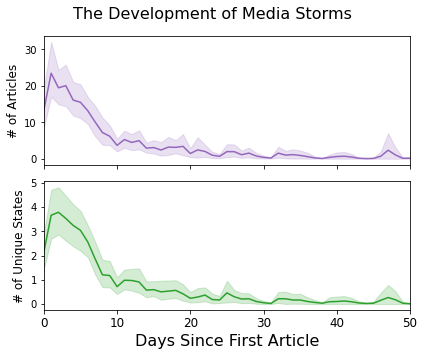

In [494]:
fig, axs = plt.subplots(2, figsize=(6, 5), sharex=True)
sns.lineplot(data=dateCounts, x="fDayNorm", y="artCount", color=colDict["purple"], ax=axs[0])
sns.lineplot(data=dateCounts, x="fDayNorm", y="uniqueStates", color=colDict["green"], ax=axs[1])

axs[0].set_ylabel("# of Articles", size=12)

axs[1].set_xlabel("Days Since First Article", size=16)
axs[1].set_xticklabels(np.arange(0, 60, 10), size=12)
#axs[1].set_xticklabels(ax.get_xticklabels(), size=12)
axs[1].set_ylabel("# of Unique States", size=12)
axs[1].set_xlim(0, 50)
fig.suptitle("The Development of Media Storms", size=16)
plt.tight_layout()


plt.savefig(FIG_PATH + "avgTimeSeries.pdf", bbox_inches = "tight")

In [184]:
dateCounts[["fDayNorm", "state", "uniqueStates", "artCount"]].head(30)

,fDayNorm,state,uniqueStates,artCount
0,0,"{Minnesota, Louisiana, New Mexico, Massachusetts}",4,26
1,1,"{Pennsylvania, California, North Carolina, Min...",10,45
2,2,"{California, Pennsylvania, Minnesota, Massachu...",7,20
3,3,{},0,1
4,4,0,0,0
5,5,0,0,0
6,6,{},0,1
7,7,0,0,0
8,8,0,0,0
9,9,0,0,0


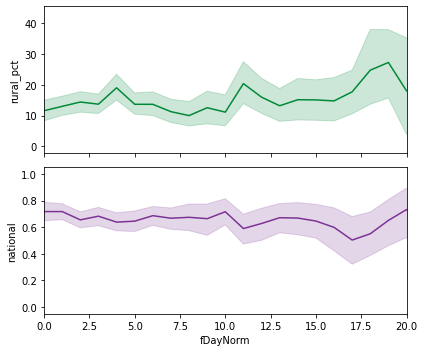

In [177]:
fig, axs = plt.subplots(2, figsize=(6, 5), sharex=True)

hasArts = dateCounts[dateCounts["artCount"] > 0]

sns.lineplot(data=hasArts, x="fDayNorm", y="rural_pct", color=PALETTE[0], ax=axs[0])
sns.lineplot(data=hasArts, x="fDayNorm", y="national", color=PALETTE[1], ax=axs[1])

"""
axs[0].set_ylabel("# of Articles", size=12)

axs[1].set_xlabel("Days Since First Article", size=16)
axs[1].set_xticklabels(np.arange(0, 60, 10), size=12)
#axs[1].set_xticklabels(ax.get_xticklabels(), size=12)
axs[1].set_ylabel("# of Unique States", size=12)
axs[1].set_xlim(0, 50)
fig.suptitle("The Development of Media Storms", size=16)
"""
plt.xlim(0, 20)
plt.tight_layout()


In [82]:
ax.set_xticklabels(np.arange(0, 50, 10))

[Text(-10.0, 0, '−10'),
 Text(0.0, 0, '0'),
 Text(10.0, 0, '10'),
 Text(20.0, 0, '20'),
 Text(30.0, 0, '30'),
 Text(40.0, 0, '40'),
 Text(50.0, 0, '50'),
 Text(60.0, 0, '60')]

In [ ]:
# stateDf["uniqueStates"] = stateDf["state"].apply(set)
#stateDf["numUniqueStates"] = len(stateDf["uniqueStates"])

In [186]:
dateCounts

,20000_90,fDayNorm,totalArts,rural_pct,national,state,artCount,countNorm,uniqueStates
0,359,0,93,8.975072,0.730769,"{Minnesota, Louisiana, New Mexico, Massachusetts}",26,0.279570,4
1,359,1,93,17.777352,0.511111,"{Pennsylvania, California, North Carolina, Min...",45,0.483871,10
2,359,2,93,20.056621,0.400000,"{California, Pennsylvania, Minnesota, Massachu...",20,0.215054,7
3,359,3,93,0.000000,1.000000,{},1,0.010753,0
4,359,4,0,0.000000,0.000000,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...
5189,295028,48,0,0.000000,0.000000,0,0,0.000000,0
5190,295028,49,0,0.000000,0.000000,0,0,0.000000,0
5191,295028,50,0,0.000000,0.000000,0,0,0.000000,0
5192,295028,51,0,0.000000,0.000000,0,0,0.000000,0


In [ ]:
#additional figure to make, what is the average evolution of all clusters 

In [ ]:
#plot for time series of non-storm articles 
rDateDf = merged.loc[merged[SCOL_NAME + "_storm"] == False, [SCOL_NAME, "date"]].groupby(by=[SCOL_NAME]).agg(list) 

In [ ]:
#get days of storms numbered by date since first article appears
rDateDf["totalArts"] = rDateDf["date"].apply(len)

In [ ]:
rDateDf["firstDay"] = pd.to_datetime(rDateDf["date"].apply(min))

In [ ]:
rDateDf = rDateDf.explode("date")

In [ ]:
rDateDf["fDayNorm"] = ((rDateDf["date"] - rDateDf["firstDay"]) / np.timedelta64(1, "D")).astype(int)

In [249]:
rDateCounts = rDateDf.reset_index()[[SCOL_NAME, "fDayNorm", "totalArts"]].groupby(by=[SCOL_NAME, "fDayNorm"])\
.agg(list) #.reset_index() #.head(30)

rDateCounts["artCount"] = rDateCounts["totalArts"].apply(len)
rDateCounts["totalArts"] = rDateCounts["totalArts"].apply(getFirst)

rDateCounts["countNorm"] = rDateCounts["artCount"] / rDateCounts["totalArts"]

In [ ]:
id=rDateCounts.index.get_level_values(1)
idx=pd.MultiIndex.from_product([rDateCounts.index.levels[0],list(range(int(id.min()),int(id.max())))])
rDateCounts = rDateCounts.reindex(idx, fill_value=0).reset_index()

rDateCounts = rDateCounts.rename(columns={"level_1":"fDayNorm"})

In [163]:
largeClusts = dateDf[dateDf["totalArts"] > 600].reset_index()[SCOL_NAME].unique()

In [164]:
largeClusts

array([ 533,  608, 6876, 8088])

Text(0, 0.5, 'article count')

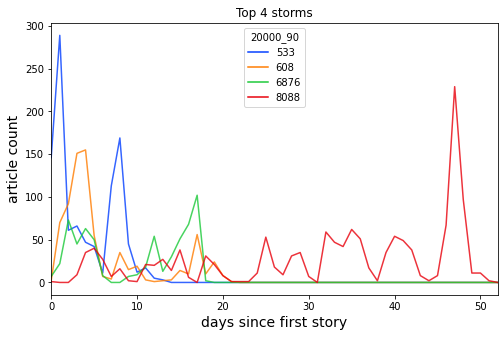

In [219]:
fix, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(x="fDayNorm", y="artCount", hue=SCOL_NAME, data=dateCounts[dateCounts[SCOL_NAME].isin(largeClusts)], palette="bright", legend=True, alpha=.8, ax=ax)
ax.set_xlim()
ax.set_xlim(0, 52)
ax.set_title("Top 4 storms")
ax.set_xlabel("days since first story", size=14)
ax.set_ylabel("article count", size=14)
#ax.set_xticks(np.arange(-4, 4, 1))

In [222]:
c4817 = merged.loc[merged[SCOL_NAME] == 6876]

In [223]:
#Biden's infrastructure bill 
c4817.sample(20).sort_values("date")[["date", "title", "content"]]

,date,title,content
1662870,2020-10-10,Five things to know about Supreme Court nomine...,WASHINGTON — Confirmation hearings begin Monda...
1662932,2020-10-10,Five things to know about Supreme Court nomine...,WASHINGTON — Confirmation hearings begin Monda...
1663390,2020-10-10,Five things to know about court nominee Amy Co...,WASHINGTON — Confirmation hearings begin Monda...
1666816,2020-10-10,Details of Amy Coney Barrett's Monday confirma...,Two U.S. senators from Indiana and a former la...
1666880,2020-10-10,Five things to know about court nominee Amy Co...,Confirmation hearings begin Monday for Preside...


In [ ]:
#fit beta distributions to the time-series 
#TODO: 
#normalize the data between zero and one on the x axis 
#use norms from up above (pdf) for y axis
#use scipy beta fit 
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html

In [258]:
#get empirical cdf of how many storms are left after a certain day 



,20000_90,fDayNorm,totalArts,rural_pct,national,state,artCount,countNorm,uniqueStates
0,359,0,93,8.975072,0.730769,"{Minnesota, Louisiana, New Mexico, Massachusetts}",26,0.279570,4
1,359,1,93,17.777352,0.511111,"{Pennsylvania, California, North Carolina, Min...",45,0.483871,10
2,359,2,93,20.056621,0.400000,"{California, Pennsylvania, Minnesota, Massachu...",20,0.215054,7
3,359,3,93,0.000000,1.000000,{},1,0.010753,0
4,359,4,0,0.000000,0.000000,0,0,0.000000,0
...,...,...,...,...,...,...,...,...,...
5189,295028,48,0,0.000000,0.000000,0,0,0.000000,0
5190,295028,49,0,0.000000,0.000000,0,0,0.000000,0
5191,295028,50,0,0.000000,0.000000,0,0,0.000000,0
5192,295028,51,0,0.000000,0.000000,0,0,0.000000,0


In [261]:
dateCounts = dateDf.reset_index()[[SCOL_NAME, "pDayNorm", "totalArts", "national", "state", "rural_pct"]].groupby(by=[SCOL_NAME, "pDayNorm"])\
.agg(list) #.reset_index() #.head(30)

dateCounts["artCount"] = dateCounts["totalArts"].apply(len)
dateCounts["totalArts"] = dateCounts["totalArts"].apply(getFirst)

dateCounts["countNorm"] = dateCounts["artCount"] / dateCounts["totalArts"]

#id=dateCounts.index.get_level_values(1)
#idx=pd.MultiIndex.from_product([dateCounts.index.levels[0],list(range(int(id.min()),int(id.max())))])
#dateCounts = dateCounts.reindex(idx, fill_value=0).reset_index()

dateCounts = dateCounts.rename(columns={"level_1":"pDayNorm"})

In [274]:
#how long each story is 
stormLens = dateDf.reset_index()[[SCOL_NAME, "date"]].groupby([SCOL_NAME]).agg(lambda x: ((max(x) - min(x)) / np.timedelta64(1, "D")) + 1)

In [281]:
#do this for all stories 
nonStormLens = merged[[SCOL_NAME, "date"]].groupby([SCOL_NAME]).agg(lambda x: ((max(x) - min(x)) / np.timedelta64(1, "D")) + 1)

In [495]:
tab10

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

<ipython-input-502-f28b3eb815da>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), size=12)
<ipython-input-502-f28b3eb815da>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(ax.get_yticklabels(), size=12)


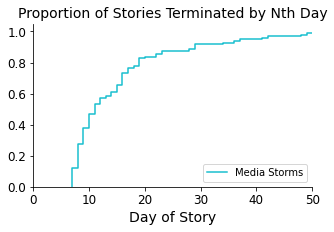

In [502]:
fig, ax = plt.subplots(figsize = (5, 3))

sns.ecdfplot(data=stormLens, x="date", ax=ax, label="Media Storms", color=colDict["turqoise"], linestyle='-')
sns.ecdfplot(data=nonStormLens, x="date", ax=ax, label="Non Media Storms", color="#00274C", linestyle='-.' )

ax.set_xlim(0, 50)
ax.set_ylim(0, 1.05)
ax.set_title("Proportion of Stories Terminated by Nth Day", size=14)
ax.set_xlabel("Day of Story", size=14)
ax.set_xticklabels(ax.get_xticklabels(), size=12)
ax.set_yticklabels(ax.get_yticklabels(), size=12)
ax.set_ylabel("")
ax.legend(loc="lower right")

sns.despine()
plt.savefig(FIG_PATH + "ecdf.pdf", bbox_inches="tight")

In [318]:
#how many storms are under 12 days 
stormDf[stormDf["stormDay"] < 12]

NameError: name 'stormDf' is not defined

<Axes: xlabel='date', ylabel='Count'>

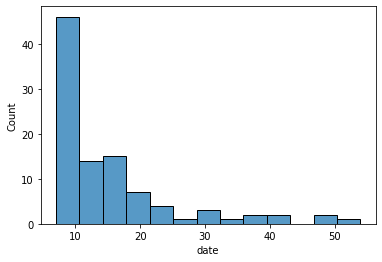

In [278]:
sns.histplot(data=stormLens, x="date")